<a href="https://colab.research.google.com/github/kdrm12/KP-Nutrifood-FakeNews/blob/main/Stage_2_Classification_with_Transformer_(Fake_News).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download Library**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 33.1 MB/s 
     |████████████████████████████████| 120 kB 61.2 MB/s 
     |████████████████████████████████| 6.6 MB 45.8 MB/s 


# **Import Library**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import re
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

import transformers
from transformers import BertTokenizer, BertConfig

# **Load Dataset**

In [ ]:
train_url='https://drive.google.com/uc?id=' + '1D2tHzT8ez_n7pDtJ2lYfG7GhDBGRD80E'
df_train = pd.read_csv(train_url)
df_train

,title,text,subject,date,output
0,wikileaks exposes clinton campaign in cahoots ...,offici within democrat nomine hillari clinton ...,politics,"Oct 11, 2016",1
1,nancy pelosi slams ‘trumpian stupidity’ and h...,donald trump face furiou backlash result recen...,news,"August 11, 2016",1
2,holy moly! trump gives epic news conference…sl...,trump press confer today jim acosta cnn bombar...,left-news,"Feb 16, 2017",1
3,brazil's congress blocks corruption charges ag...,brasilia reuter lower hous brazil congress vot...,worldnews,"October 25, 2017",0
4,greece and turkey trade barbs as erdogan visit...,athen reuter greec turkey squar old disput thu...,worldnews,"December 7, 2017",0
...,...,...,...,...,...
30909,belgian trial of paris attack suspect postpone...,brussel reuter belgian trial key suspect islam...,worldnews,"December 18, 2017",0
30910,the woman who moved freedom loving americans t...,day vote becki gerritson us congress alabama n...,left-news,"Dec 13, 2015",1
30911,veteran spy: trump trading secret info with r...,connect donald trump presidenti campaign vladi...,news,"October 31, 2016",1
30912,saudi clerics detained in apparent bid to sile...,reuter sever promin saudi cleric detain appar ...,worldnews,"September 10, 2017",0


In [ ]:
# drop kolom title, subject, date
train = df_train.drop(['title', 'subject', 'date'], axis=1)

In [ ]:
train

,text,output
0,offici within democrat nomine hillari clinton ...,1
1,donald trump face furiou backlash result recen...,1
2,trump press confer today jim acosta cnn bombar...,1
3,brasilia reuter lower hous brazil congress vot...,0
4,athen reuter greec turkey squar old disput thu...,0
...,...,...
30909,brussel reuter belgian trial key suspect islam...,0
30910,day vote becki gerritson us congress alabama n...,1
30911,connect donald trump presidenti campaign vladi...,1
30912,reuter sever promin saudi cleric detain appar ...,0


In [ ]:
y_train = train["output"].values

# **Feature Engineering**

In [ ]:
corpus = train["text"]
maxlen = 50

## tambahkan special tokens
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## membuat masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized]

## membuat padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]

## membuat idx
idx = [tokenizer.convert_tokens_to_ids(seq.split(" ")) for seq in txt2seq]

## membuat segments
segments = []
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## membuat fitur matrix
X_train = [np.asarray(idx, dtype='int32'),
           np.asarray(masks, dtype='int32'),
           np.asarray(segments, dtype='int32')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
Token indices sequence length is longer than the specified maximum sequence length for this model (712 > 512). Running this sequence through the model will result in indexing errors


# **Buat Model**

## GELU

In [ ]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
segments = layers.Input((50), dtype="int32", name="input_segments")
## config Bert
config = BertConfig(
            # vocab_size=30522,
            # hidden_size=768,
            # num_hidden_layers=12,
            # num_attention_heads=12,
            # intermediate_size=3072,
            hidden_act="gelu"
            # hidden_dropout_prob=0.2,
            # attention_probs_dropout_prob=0.2
            # max_position_embeddings=512,
            # type_vocab_size=2,
            # initializer_range=0.02,
            # layer_norm_eps=1e-12,
            # pad_token_id=0,
            # position_embedding_type="absolute",
            # use_cache=True,
            # classifier_dropout=None
        )
## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased", config = config)
print(nlp.config)
bert_out = nlp([idx, masks, segments])[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(1, activation='sigmoid')(x)
## compile
model = models.Model([idx, masks, segments], y_out)
for layer in model.layers[:4]:
    layer.trainable = False
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer

## RELU

In [ ]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
segments = layers.Input((50), dtype="int32", name="input_segments")
## config Bert
config = BertConfig(
            # vocab_size=30522,
            # hidden_size=768,
            # num_hidden_layers=12,
            # num_attention_heads=12,
            # intermediate_size=3072,
            hidden_act="relu"
            # hidden_dropout_prob=0.2,
            # attention_probs_dropout_prob=0.2
            # max_position_embeddings=512,
            # type_vocab_size=2,
            # initializer_range=0.02,
            # layer_norm_eps=1e-12,
            # pad_token_id=0,
            # position_embedding_type="absolute",
            # use_cache=True,
            # classifier_dropout=None
        )
## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased", config = config)
print(nlp.config)
bert_out = nlp([idx, masks, segments])[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(1, activation='sigmoid')(x)
## compile
model_1 = models.Model([idx, masks, segments], y_out)
for layer in model_1.layers[:4]:
    layer.trainable = False
model_1.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model_1.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLay

## SILU

In [ ]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
segments = layers.Input((50), dtype="int32", name="input_segments")
## config Bert
config = BertConfig(
            # vocab_size=30522,
            # hidden_size=768,
            # num_hidden_layers=12,
            # num_attention_heads=12,
            # intermediate_size=3072,
            hidden_act="silu"
            # hidden_dropout_prob=0.2,
            # attention_probs_dropout_prob=0.2
            # max_position_embeddings=512,
            # type_vocab_size=2,
            # initializer_range=0.02,
            # layer_norm_eps=1e-12,
            # pad_token_id=0,
            # position_embedding_type="absolute",
            # use_cache=True,
            # classifier_dropout=None
        )
## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased", config = config)
print(nlp.config)
bert_out = nlp([idx, masks, segments])[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(1, activation='sigmoid')(x)
## compile
model_2 = models.Model([idx, masks, segments], y_out)
for layer in model_2.layers[:4]:
    layer.trainable = False
model_2.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model_2.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "silu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLay

# **Latih Model**

## GELU

### Result

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## tambah early stopping: membuat model berhenti saat ingin overfitting ketika dilatih
early_stopping = EarlyStopping(patience=10)
## train
training = model.fit(x=X_train, y=y_train,
                     batch_size=64,
                     epochs=200,
                     # steps_per_epoch=100,
                     shuffle=True,
                     verbose=1,
                     callbacks=[early_stopping],
                     validation_split=0.3)
# ## test
# predicted_prob = model.predict(X_test)
# predicted = [dic_y_mapping[np.argmax(pred)] for pred in
#              predicted_prob]

Epoch 1/200
339/339 [==============================] - 123s 322ms/step - loss: 0.2168 - accuracy: 0.9183 - val_loss: 0.0965 - val_accuracy: 0.9666
Epoch 2/200
339/339 [==============================] - 106s 314ms/step - loss: 0.1116 - accuracy: 0.9605 - val_loss: 0.0786 - val_accuracy: 0.9719
Epoch 3/200
339/339 [==============================] - 106s 314ms/step - loss: 0.0880 - accuracy: 0.9684 - val_loss: 0.0559 - val_accuracy: 0.9821
Epoch 4/200
339/339 [==============================] - 106s 314ms/step - loss: 0.0753 - accuracy: 0.9738 - val_loss: 0.0485 - val_accuracy: 0.9834
Epoch 5/200
339/339 [==============================] - 106s 313ms/step - loss: 0.0764 - accuracy: 0.9731 - val_loss: 0.0458 - val_accuracy: 0.9849
Epoch 6/200
339/339 [==============================] - 106s 313ms/step - loss: 0.0736 - accuracy: 0.9745 - val_loss: 0.0401 - val_accuracy: 0.9872
Epoch 7/200
339/339 [==============================] - 106s 313ms/step - loss: 0.0639 - accuracy: 0.9778 - val_loss: 0

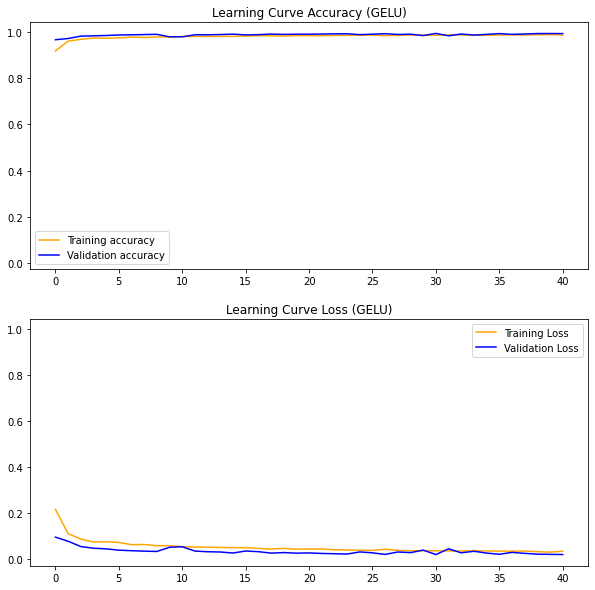

In [ ]:
acc = training.history['accuracy']
val_acc = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(10, 10))

ax[0].plot(epochs, acc, 'orange', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set(title='Learning Curve Accuracy (GELU)')
ax[0].legend()

ax[1].plot(epochs, loss, 'orange', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set(title='Learning Curve Loss (GELU)')
ax[1].legend()

plt.show()

### Save Model

In [ ]:
model.save("model_1.h5")

### Save Training Model History

In [ ]:
hist_df = pd.DataFrame(training.history)

# save to csv:
hist_csv_file = 'model1_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## RELU

### Result

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## tambah early stopping: membuat model berhenti saat ingin overfitting ketika dilatih
early_stopping = EarlyStopping(patience=10)
## train
training_1 = model_1.fit(x=X_train, y=y_train,
                     batch_size=64,
                     epochs=200,
                     # steps_per_epoch=100,
                     shuffle=True,
                     verbose=1,
                     callbacks=[early_stopping],
                     validation_split=0.3)
# ## test
# predicted_prob = model.predict(X_test)
# predicted = [dic_y_mapping[np.argmax(pred)] for pred in
#              predicted_prob]

Epoch 1/200
339/339 [==============================] - 110s 293ms/step - loss: 0.5284 - accuracy: 0.7904 - val_loss: 0.3230 - val_accuracy: 0.9289
Epoch 2/200
339/339 [==============================] - 97s 285ms/step - loss: 0.2856 - accuracy: 0.9097 - val_loss: 0.2117 - val_accuracy: 0.9379
Epoch 3/200
339/339 [==============================] - 97s 285ms/step - loss: 0.2062 - accuracy: 0.9314 - val_loss: 0.1381 - val_accuracy: 0.9653
Epoch 4/200
339/339 [==============================] - 96s 283ms/step - loss: 0.1675 - accuracy: 0.9436 - val_loss: 0.1020 - val_accuracy: 0.9744
Epoch 5/200
339/339 [==============================] - 96s 283ms/step - loss: 0.1495 - accuracy: 0.9498 - val_loss: 0.0858 - val_accuracy: 0.9798
Epoch 6/200
339/339 [==============================] - 96s 284ms/step - loss: 0.1312 - accuracy: 0.9578 - val_loss: 0.0742 - val_accuracy: 0.9813
Epoch 7/200
339/339 [==============================] - 96s 283ms/step - loss: 0.1204 - accuracy: 0.9604 - val_loss: 0.0750 

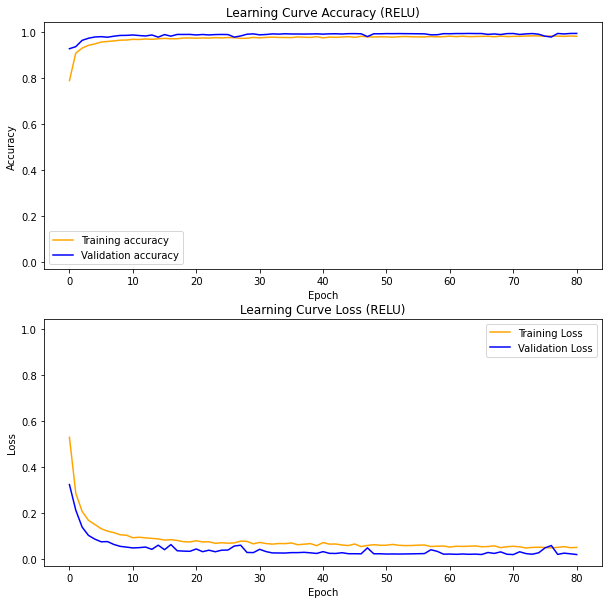

In [ ]:
acc = training_1.history['accuracy']
val_acc = training_1.history['val_accuracy']
loss = training_1.history['loss']
val_loss = training_1.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(10, 10))

ax[0].plot(epochs, acc, 'orange', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set(title='Learning Curve Accuracy (RELU)')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].plot(epochs, loss, 'orange', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set(title='Learning Curve Loss (RELU)')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

### Save Model

In [ ]:
model_1.save("model_2.h5")

### Save Training Model History

In [ ]:
hist_df = pd.DataFrame(training_1.history)

# save to csv:
hist_csv_file = 'model2_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## SILU

### Result

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## tambah early stopping: membuat model berhenti saat ingin overfitting ketika dilatih
early_stopping = EarlyStopping(patience=10)
## train
training_2 = model_2.fit(x=X_train, y=y_train,
                     batch_size=64,
                     epochs=200,
                     # steps_per_epoch=100,
                     shuffle=True,
                     verbose=1,
                     callbacks=[early_stopping],
                     validation_split=0.3)
# ## test
# predicted_prob = model.predict(X_test)
# predicted = [dic_y_mapping[np.argmax(pred)] for pred in
#              predicted_prob]

Epoch 1/200
339/339 [==============================] - 115s 306ms/step - loss: 0.5478 - accuracy: 0.7197 - val_loss: 0.3830 - val_accuracy: 0.8380
Epoch 2/200
339/339 [==============================] - 101s 298ms/step - loss: 0.4948 - accuracy: 0.7610 - val_loss: 0.4145 - val_accuracy: 0.8081
Epoch 3/200
339/339 [==============================] - 101s 297ms/step - loss: 0.4725 - accuracy: 0.7758 - val_loss: 0.3028 - val_accuracy: 0.8873
Epoch 4/200
339/339 [==============================] - 101s 297ms/step - loss: 0.4726 - accuracy: 0.7714 - val_loss: 0.3669 - val_accuracy: 0.8279
Epoch 5/200
339/339 [==============================] - 101s 297ms/step - loss: 0.4630 - accuracy: 0.7816 - val_loss: 0.2928 - val_accuracy: 0.8919
Epoch 6/200
339/339 [==============================] - 101s 297ms/step - loss: 0.4626 - accuracy: 0.7784 - val_loss: 0.3512 - val_accuracy: 0.8354
Epoch 7/200
339/339 [==============================] - 101s 297ms/step - loss: 0.4529 - accuracy: 0.7844 - val_loss: 0

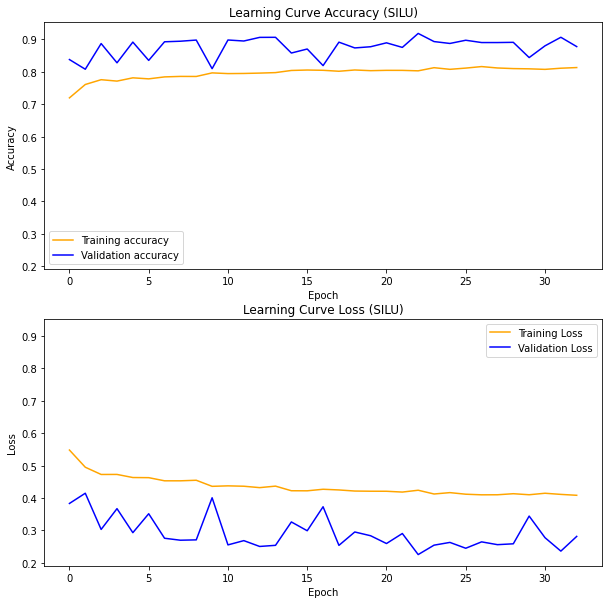

In [ ]:
acc = training_2.history['accuracy']
val_acc = training_2.history['val_accuracy']
loss = training_2.history['loss']
val_loss = training_2.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(10, 10))

ax[0].plot(epochs, acc, 'orange', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set(title='Learning Curve Accuracy (SILU)')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].plot(epochs, loss, 'orange', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set(title='Learning Curve Loss (SILU)')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

### Save Model

In [ ]:
model_2.save("model_3.h5")

### Save Training Model History

In [ ]:
hist_df = pd.DataFrame(training_2.history)

# save to csv:
hist_csv_file = 'model3_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)